In [2]:
from datetime import datetime 
import pandas as pd
from global_map import global_map
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import sys
import os
import glob
import warnings
import matplotlib as mpl
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy as crt
sys.path.append("..")
from path_dict import path_dict


# PLOTTING inputs
cmap = mpl.colormaps['viridis'].resampled(20)
cmap2 = mpl.colormaps['hot_r']#.resampled(20)
cmap3 = mpl.colormaps['magma_r'].resampled(20)
cmap4 = mpl.colormaps['seismic']#.resampled(20)

In [3]:
# locate timeseries 
dir_data = '/gpfs/work1/0/einf3499/06_model_runs'
dir_wl_slr = os.path.join(dir_data,'02_slr_tide_surge_runs','model_input_ERA5_2023')
dir_wl_noslr = os.path.join(dir_data,'02_slr_tide_surge_runs','model_input_ERA5_2023_noSLR')
dir_tide_slr = os.path.join(dir_data,'99_slr_tide_surge_runs_oldproject','model_input_tide_2023')
dir_tide_noslr = os.path.join(dir_data,'02_slr_tide_surge_runs','model_input_TIDE_2023_noSLR')

In [9]:
# station ids
stations_gtsm = (39598,"IJmuiden") 

In [5]:
def read_his_file(path):
    ds = xr.open_dataset(path)
    ds = ds.assign_coords({'stations': ds.stations})
    keys = list(ds.keys()) # remove all variables except water level
    if 'waterlevel' in keys:
        keys.remove('waterlevel')
    if 'patm' in keys:
        keys.remove('patm')
    ds = ds.drop(keys)
    return ds

In [6]:
# Open model data
ds_wl_slr = read_his_file(os.path.join(dir_wl_slr,'output','gtsm_fine_0000_his.nc'))
ds_wl_noslr = read_his_file(os.path.join(dir_wl_noslr,'output','gtsm_fine_0000_his.nc'))
ds_tide_slr = read_his_file(os.path.join(dir_tide_slr,'output','gtsm_fine_0000_his.nc'))
ds_tide_noslr = read_his_file(os.path.join(dir_tide_noslr,'output','gtsm_fine_0000_his_copy.nc'))

In [7]:
ds_wl_slr_sel = ds_wl_slr.sel(stations=stations_gtsm[0],drop=True).squeeze()
ds_wl_noslr_sel = ds_wl_noslr.sel(stations=stations_gtsm[0],drop=True).squeeze()
ds_tide_slr_sel = ds_tide_slr.sel(stations=stations_gtsm[0],drop=True).squeeze()
ds_tide_noslr_sel = ds_tide_noslr.sel(stations=stations_gtsm[0],drop=True).squeeze()

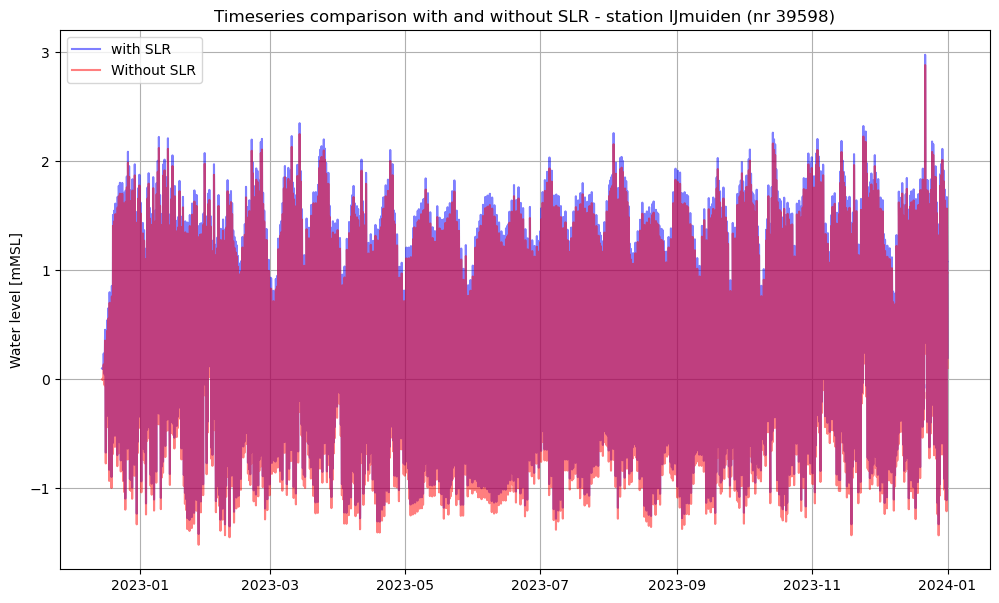

In [13]:
### Make comparison of single station timeseries
# Waterlevel
fig, ax = plt.subplots(figsize=(12,7))
ts = ax.plot(ds_wl_slr_sel['time'].values,ds_wl_slr_sel['waterlevel'].values,'b-',alpha=0.5,label='with SLR');
ts3 = ax.plot(ds_wl_noslr_sel['time'].values,ds_wl_noslr_sel['waterlevel'].values,'r-',alpha=0.5,label='Without SLR');
ax.set_ylabel('Water level [mMSL]')
ax.legend()
ax.grid(); ax.title.set_text(f'Timeseries comparison with and without SLR - station {stations_gtsm[1]} (nr {stations_gtsm[0]})')

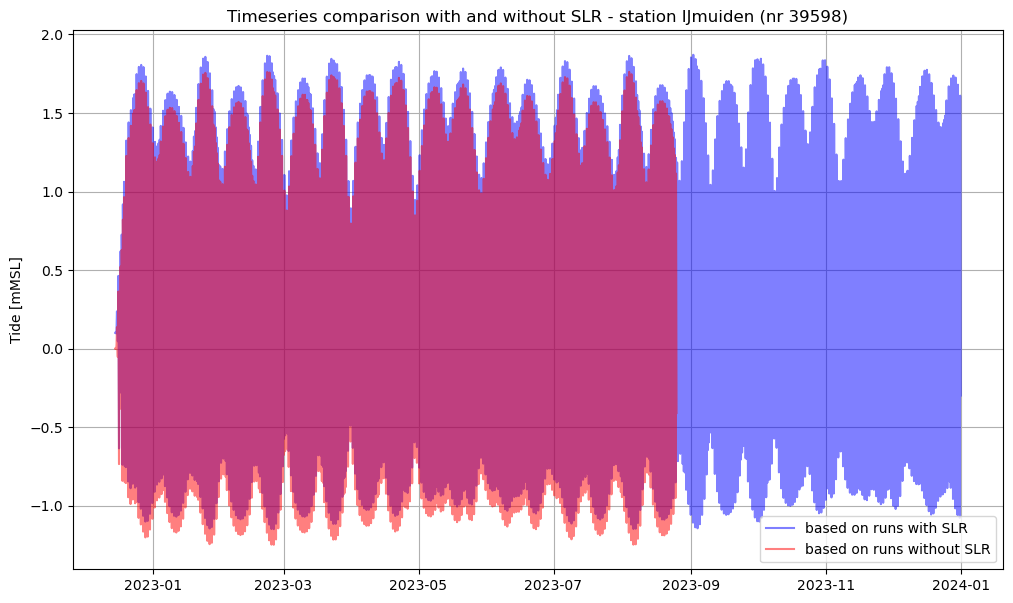

In [14]:
#tide
fig, ax = plt.subplots(figsize=(12,7))
ts = ax.plot(ds_tide_slr_sel['time'].values,ds_tide_slr_sel['waterlevel'].values,'b-',alpha=0.5,label='based on runs with SLR');
ts3 = ax.plot(ds_tide_noslr_sel['time'].values,ds_tide_noslr_sel['waterlevel'].values,'r-',alpha=0.5,label='based on runs without SLR');
ax.legend()
ax.set_ylabel('Tide [mMSL]')
ax.grid(); ax.title.set_text(f'Timeseries comparison with and without SLR - station {stations_gtsm[1]} (nr {stations_gtsm[0]})')

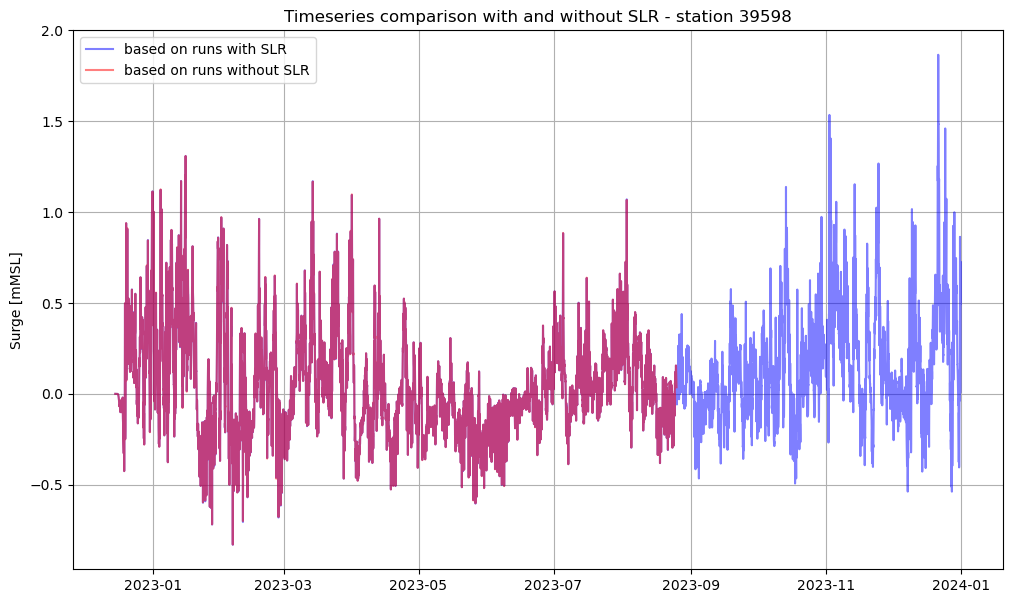

In [15]:
# surge
ds_surge_slr_sel = ds_wl_slr_sel - ds_tide_slr_sel
ds_surge_noslr_sel = ds_wl_noslr_sel - ds_tide_noslr_sel
fig, ax = plt.subplots(figsize=(12,7))
ts = ax.plot(ds_surge_slr_sel['time'].values,ds_surge_slr_sel['waterlevel'].values,'b-',alpha=0.5,label='based on runs with SLR');
ts3 = ax.plot(ds_surge_noslr_sel['time'].values,ds_surge_noslr_sel['waterlevel'].values,'r-',alpha=0.5,label='based on runs without SLR');
ax.legend()
ax.set_ylabel('Surge [mMSL]')
ax.grid(); ax.title.set_text(f'Timeseries comparison with and without SLR - station {stations_gtsm[0]}')

In [17]:
# Check WL difference when mean is subtracted
print("The mean of surge levels in 2023 (runs with SLR): " + str(format(ds_surge_slr_sel['waterlevel'].sel(time=slice("2023-01-01","2023-08-01")).mean(dim='time').values,'.4f')) + ' m')
print("The mean of surge levels in 2023 (runs without SLR): " + str(format(ds_surge_noslr_sel['waterlevel'].sel(time=slice("2023-01-01","2023-08-01")).mean(dim='time').values,'.4f')) + ' m')

The mean of surge levels in 2023 (runs with SLR): 0.0317 m
The mean of surge levels in 2023 (runs without SLR): 0.0319 m


In [18]:
### Compare maps of water levels between runs with and without SLR
bbox = [2.3408,51.3167,7.4165,54.014]

In [60]:
# get surge just for the NL coast (within bbox)
ds_surge_slr = ds_wl_slr.sel(time=slice('2023-01-01','2023-02-28'),drop=True).where((ds_wl_slr.station_x_coordinate > bbox[0]) & (ds_wl_slr.station_x_coordinate < bbox[2]) & (ds_wl_slr.station_y_coordinate > bbox[1]) & (ds_wl_slr.station_y_coordinate < bbox[3]),drop=True) - ds_tide_slr.sel(time=slice('2023-01-01','2023-01-31'),drop=True).where((ds_wl_slr.station_x_coordinate > bbox[0]) & (ds_wl_slr.station_x_coordinate < bbox[2]) & (ds_wl_slr.station_y_coordinate > bbox[1]) & (ds_wl_slr.station_y_coordinate < bbox[3]),drop=True)
ds_surge_noslr = ds_wl_noslr.sel(time=slice('2023-01-01','2023-02-28'),drop=True).where((ds_wl_slr.station_x_coordinate > bbox[0]) & (ds_wl_slr.station_x_coordinate < bbox[2]) & (ds_wl_slr.station_y_coordinate > bbox[1]) & (ds_wl_slr.station_y_coordinate < bbox[3]),drop=True) - ds_tide_noslr.sel(time=slice('2023-01-01','2023-01-31'),drop=True).where((ds_wl_slr.station_x_coordinate > bbox[0]) & (ds_wl_slr.station_x_coordinate < bbox[2]) & (ds_wl_slr.station_y_coordinate > bbox[1]) & (ds_wl_slr.station_y_coordinate < bbox[3]),drop=True)


In [61]:
# Get SLR value for the given year within the bbox (Netherlands coast)
rel_SLR = ds_wl_slr.sel(time=slice('2023-01-01','2023-02-28'),drop=True).where((ds_wl_slr.station_x_coordinate > bbox[0]) & (ds_wl_slr.station_x_coordinate < bbox[2]) & (ds_wl_slr.station_y_coordinate > bbox[1]) & (ds_wl_slr.station_y_coordinate < bbox[3]),drop=True) - ds_wl_noslr.sel(time=slice('2023-01-01','2023-02-28'),drop=True).where((ds_wl_slr.station_x_coordinate > bbox[0]) & (ds_wl_slr.station_x_coordinate < bbox[2]) & (ds_wl_slr.station_y_coordinate > bbox[1]) & (ds_wl_slr.station_y_coordinate < bbox[3]),drop=True)
rel_SLR_mean = rel_SLR['waterlevel'].mean().values

Text(0.5, 0.98, '2023-01-01 00:00:00')

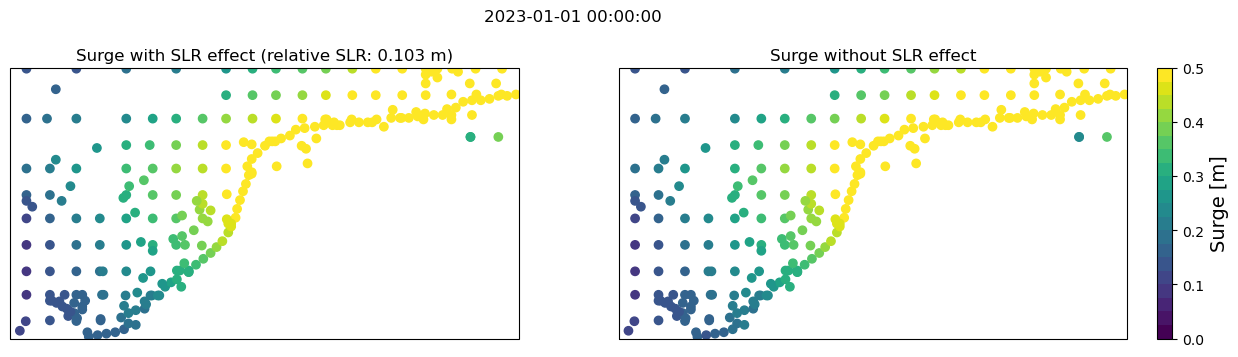

In [55]:
# plot maps of surge for a given time moment (in this case first timestep of January)
timestamp = '2023-01-01 00:00:00'
lims = [0,0.5] # colorbar lims


fig = plt.figure(figsize=(15,4))
axes_class = (GeoAxes, dict(projection=crt.crs.PlateCarree()))
axs = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(1, 2), share_all=True, axes_pad=1,cbar_location='right',cbar_mode='single',cbar_size='3%',cbar_pad=0.3, label_mode='keep')
ax = axs[0]
bs = ax.scatter(x=ds_surge_slr.station_x_coordinate.values,y=ds_surge_slr.station_y_coordinate.values,c=ds_surge_slr['waterlevel'].sel(time=timestamp).values,transform=crt.crs.PlateCarree(),cmap=cmap,vmin=lims[0],vmax=lims[1]); 
ax.title.set_text(f"Surge with SLR effect (relative SLR: {rel_SLR_mean:.3f} m)")
ax.set_xlim([bbox[0],bbox[2]])
ax.set_ylim([bbox[1],bbox[3]])
ax = axs[1]
bs = ax.scatter(x=ds_surge_noslr.station_x_coordinate.values,y=ds_surge_noslr.station_y_coordinate.values,c=ds_surge_noslr['waterlevel'].sel(time=timestamp).values,transform=crt.crs.PlateCarree(),cmap=cmap,vmin=lims[0],vmax=lims[1]);
ax.title.set_text(f"Surge without SLR effect")
cbar = ax.cax.colorbar(bs); cbar.set_label('Surge [m]',fontsize=14)
plt.suptitle(timestamp)

Text(0.5, 0.98, 'Mean over the month: 2023-01')

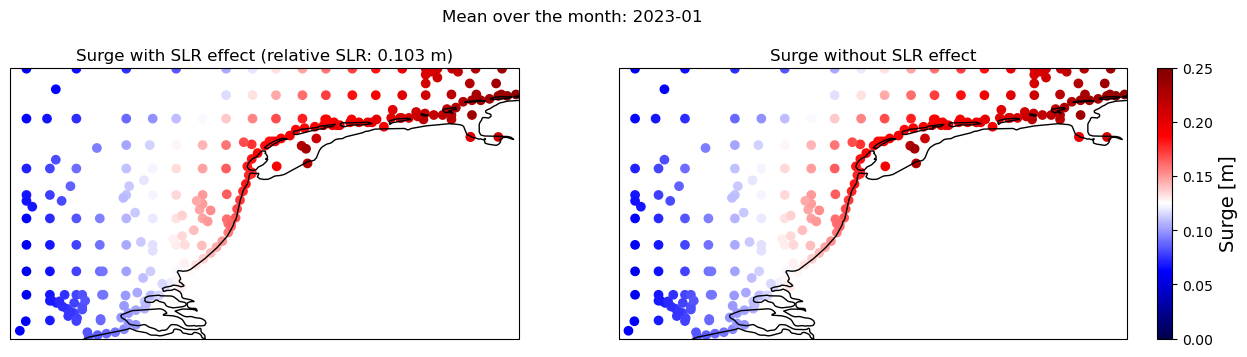

In [56]:
# plot maps of surge averaged over a month (in this case January)
timestamp = '2023-01'
lims = [0,0.25] # colorbar lims

fig = plt.figure(figsize=(15,4))
axes_class = (GeoAxes, dict(projection=crt.crs.PlateCarree()))
axs = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(1, 2), share_all=True, axes_pad=1,cbar_location='right',cbar_mode='single',cbar_size='3%',cbar_pad=0.3, label_mode='keep')
ax = axs[0]
bs = ax.scatter(x=ds_surge_slr.station_x_coordinate.values,y=ds_surge_slr.station_y_coordinate.values,c=ds_surge_slr['waterlevel'].sel(time=timestamp).mean(dim='time').values,transform=crt.crs.PlateCarree(),cmap=cmap4,vmin=lims[0],vmax=lims[1]); 
ax.title.set_text(f"Surge with SLR effect (relative SLR: {rel_SLR_mean:.3f} m)")
ax.coastlines()
ax.set_xlim([bbox[0],bbox[2]])
ax.set_ylim([bbox[1],bbox[3]])
ax = axs[1]
bs = ax.scatter(x=ds_surge_noslr.station_x_coordinate.values,y=ds_surge_noslr.station_y_coordinate.values,c=ds_surge_noslr['waterlevel'].sel(time=timestamp).mean(dim='time').values,transform=crt.crs.PlateCarree(),cmap=cmap4,vmin=lims[0],vmax=lims[1]);
ax.title.set_text(f"Surge without SLR effect")
cbar = ax.cax.colorbar(bs); cbar.set_label('Surge [m]',fontsize=14)
ax.coastlines()
plt.suptitle('Mean over the month: ' + timestamp)

Text(0.5, 0.98, 'Mean over the month: 2023-01')

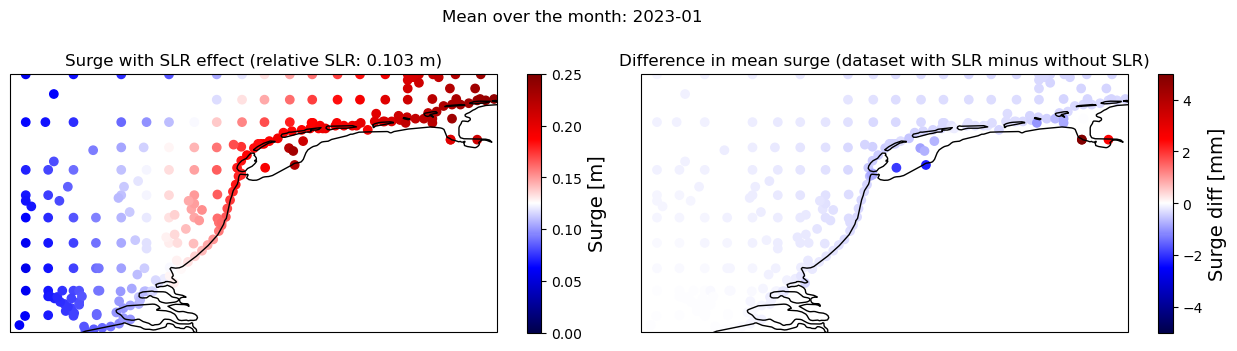

In [57]:
# plot maps of surge averaged over a month (in this case January) - with difference plot
timestamp = '2023-01'
lims = [0,0.25] # colorbar lims
lims_diff = [-5, 5] #mm
ds_diff = ds_surge_slr - ds_surge_noslr

fig = plt.figure(figsize=(15,4))
axes_class = (GeoAxes, dict(projection=crt.crs.PlateCarree()))
axs = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(1, 2), share_all=True, axes_pad=1,cbar_location='right',cbar_mode='each',cbar_size='3%',cbar_pad=0.3, label_mode='keep')
ax = axs[0]
bs = ax.scatter(x=ds_surge_slr.station_x_coordinate.values,y=ds_surge_slr.station_y_coordinate.values,c=ds_surge_slr['waterlevel'].sel(time=timestamp).mean(dim='time').values,transform=crt.crs.PlateCarree(),cmap=cmap4,vmin=lims[0],vmax=lims[1]); 
ax.title.set_text(f"Surge with SLR effect (relative SLR: {rel_SLR_mean:.3f} m)")
ax.set_xlim([bbox[0],bbox[2]])
ax.set_ylim([bbox[1],bbox[3]])
ax.coastlines()
cbar = ax.cax.colorbar(bs); cbar.set_label('Surge [m]',fontsize=14)

ax = axs[1]
bs = ax.scatter(x=ds_surge_slr.station_x_coordinate.values,y=ds_surge_slr.station_y_coordinate.values,c=ds_diff['waterlevel'].sel(time=timestamp).mean(dim='time').values*1000,transform=crt.crs.PlateCarree(),cmap=cmap4,vmin=lims_diff[0],vmax=lims_diff[1]);
ax.title.set_text(f"Difference in mean surge (dataset with SLR minus without SLR)")
cbar = ax.cax.colorbar(bs); cbar.set_label('Surge diff [mm]',fontsize=14)
ax.coastlines()
plt.suptitle('Mean over the month: ' + timestamp)

In [ ]:
'''
# Code for finding station number by coordinates
lat = 29.3
lon = -91.83

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(ds_surge_cds.station_y_coordinate.values-lat)
abslon = np.abs(ds_surge_cds.station_x_coordinate.values-lon)
c = np.maximum(abslon, abslat)

([iloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
ds_surge_cds.isel(stations=iloc).load()
'''